In [1]:
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import random_split
from torchvision.datasets import CIFAR10

import os
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def get_best_device():
    if torch.backends.mps.is_built():
        device = torch.device("mps")
        print("Using MPS (Apple Silicon GPU)")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using CUDA (GPU)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device


device = get_best_device()

Using CUDA (GPU)


In [3]:
BATCH_SIZE = 512

transform_cifar = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)


dataset = CIFAR10(root="data", download=True, train=True, transform=transform_cifar)
dataset_train, dataset_test, dataset_validation = random_split(
    dataset, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42)
)


train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
def grayscale_processing(img):
    if len(img.shape) == 3:
        img = img.mean(dim=0, keepdim=True)
        img = img.repeat(3, 1, 1)
    else:
        img = img.mean(dim=1, keepdim=True)
        img = img.repeat(1, 3, 1, 1)
    return img

In [5]:
def plot_examples(model, num_examples=5, grayscale=False):
    i = list(range(0, num_examples*5, 5))

    for j in i:
      img = dataset_test[j][0]
      img_processed = img
      n = 2

      if grayscale:
        img_processed = grayscale_processing(img)
        n = 3

      out = model(img_processed.unsqueeze(0).to(autoencoder.device).float())[0].detach().cpu().permute(1, 2, 0).numpy()
      img = img.permute(1, 2, 0).numpy()

      fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
      ax[0].imshow(img)
      ax[0].set_title('Original Image')

      if grayscale:
        img_processed = img_processed.permute(1, 2, 0).numpy()
        ax[1].imshow(img_processed)
        ax[1].set_title('Input to NN')

      ax[n-1].imshow(out)
      ax[n-1].set_title('Reconstructed Image')
      plt.show()

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.device = get_best_device()

        self.encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(
                in_channels=8, out_channels=12, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(
                in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(True),
        )

        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(
                in_channels=16, out_channels=12, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(
                in_channels=12, out_channels=3, kernel_size=3, stride=1, padding=1
            ),
            nn.Sigmoid(),
        )

        self.loss_history = []
        self.test_loss_history = []

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def train(self, train_loader, test_loader, epochs=10, lr=0.1, grayscale_input=False):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss().to(self.device)
        # criterion = nn.BCELoss().to(self.device)


        for epoch in range(epochs):
            epoch_loss = []
            for data in train_loader:
                x, _ = data
                x = x.to(self.device).float()
                optimizer.zero_grad()

                input = x
                if grayscale_input:
                    input = grayscale_processing(input)

                output = self(input)
                loss = criterion(output, x)
                epoch_loss.append(loss.item())
                loss.backward()
                optimizer.step()

            train_loss = np.mean(epoch_loss)
            test_loss = self.test_loss(test_loader)
            self.loss_history.append(train_loss)
            self.test_loss_history.append(test_loss)

            # if self.test_loss == min(self.test_loss_history):
            #     self.best_model = self.state_dict()

            print(f'Epoch {epoch+1}/{epochs} Train Loss: {train_loss}, Test Loss: {test_loss}')

    def test_loss(self, test_loader):
        criterion = nn.MSELoss().to(self.device)
        test_loss = []
        with torch.no_grad():
            for data in test_loader:
                x, _ = data
                x = x.to(self.device).float()
                output = self(x)
                loss = criterion(output, x)
                test_loss.append(loss.item())

        return np.mean(test_loss)

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.plot(self.test_loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Autoencoder Loss History')
        plt.show()

    # def __call__(self, x):
    #     x = x.to(self.device).float()
    #     return self.forward(x)

autoencoder = Autoencoder().to(device)
autoencoder_gray = Autoencoder().to(device)

Using CUDA (GPU)
Using CUDA (GPU)


Epoch 1/10 Train Loss: 0.040711851484036145, Test Loss: 0.02085553538054228
Epoch 2/10 Train Loss: 0.01787214150911645, Test Loss: 0.01616280749440193
Epoch 3/10 Train Loss: 0.014376329317028765, Test Loss: 0.012200245447456837
Epoch 4/10 Train Loss: 0.011752768961972073, Test Loss: 0.011216302495449781
Epoch 5/10 Train Loss: 0.0107880746592072, Test Loss: 0.010610646568238735
Epoch 6/10 Train Loss: 0.01003182316316834, Test Loss: 0.009673386346548796
Epoch 7/10 Train Loss: 0.009443077883577044, Test Loss: 0.009523436799645424
Epoch 8/10 Train Loss: 0.00907767916546215, Test Loss: 0.009011750016361475
Epoch 9/10 Train Loss: 0.008730323431141015, Test Loss: 0.00867889802902937
Epoch 10/10 Train Loss: 0.008516126807448985, Test Loss: 0.008453058823943139


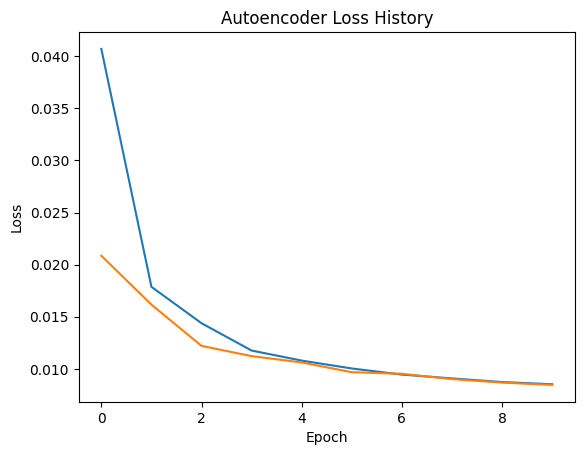

In [7]:
autoencoder.train(train_loader, test_loader, epochs=10, lr=0.001)
autoencoder.plot_loss()
# autoencoder.load_state_dict(autoencoder.best_model)

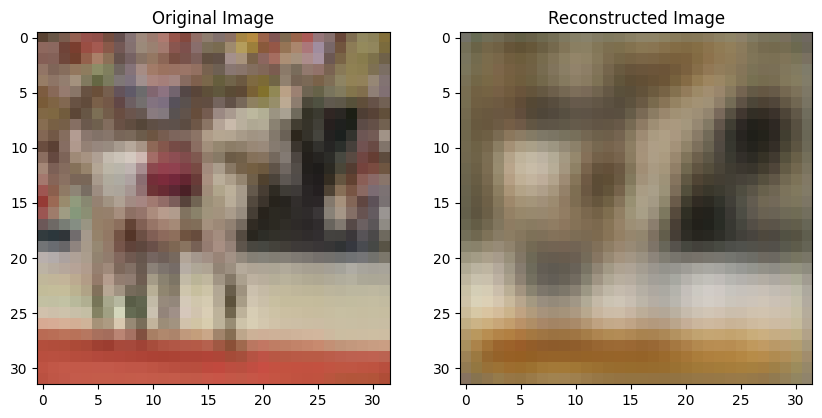

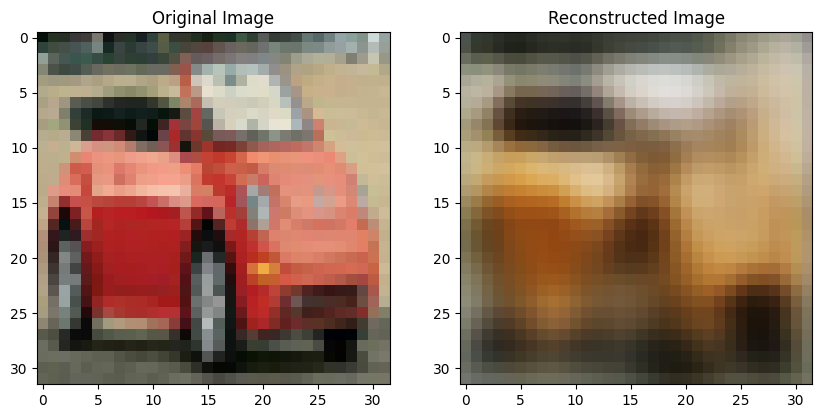

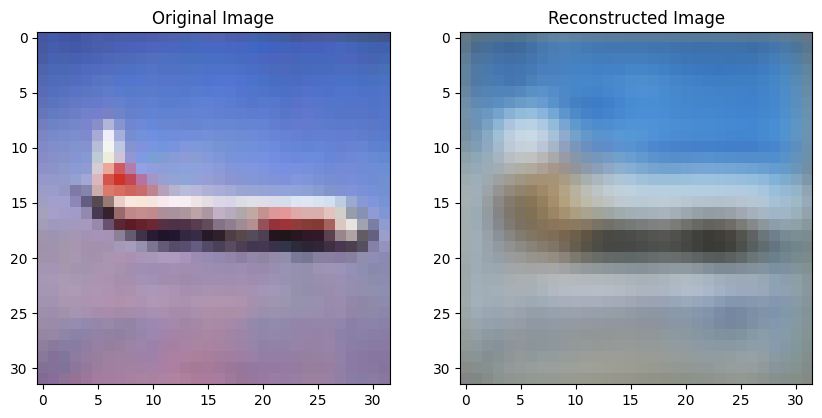

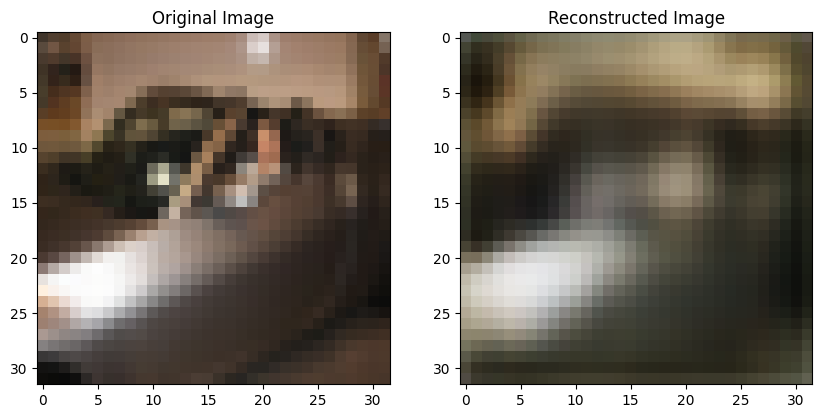

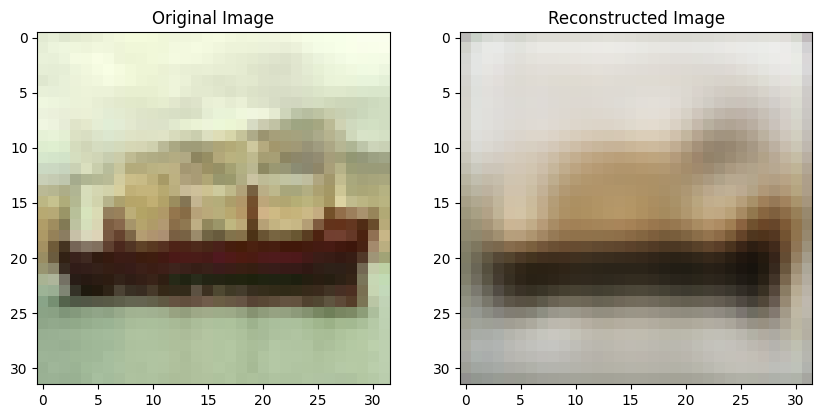

In [8]:
plot_examples(autoencoder, num_examples=5)

Epoch 1/10 Train Loss: 0.03372756212572508, Test Loss: 0.022181832045316697
Epoch 2/10 Train Loss: 0.017991019200675095, Test Loss: 0.018235581740736962
Epoch 3/10 Train Loss: 0.01610648657985126, Test Loss: 0.016798053123056888
Epoch 4/10 Train Loss: 0.014992038177066966, Test Loss: 0.015932769048959017
Epoch 5/10 Train Loss: 0.014159734231195872, Test Loss: 0.015079669374972581
Epoch 6/10 Train Loss: 0.013647260556964181, Test Loss: 0.014638503082096577
Epoch 7/10 Train Loss: 0.01321339675614351, Test Loss: 0.014394163619726896
Epoch 8/10 Train Loss: 0.01292083525582205, Test Loss: 0.01412383196875453
Epoch 9/10 Train Loss: 0.012677047213044348, Test Loss: 0.013946698419749737
Epoch 10/10 Train Loss: 0.012467237790645678, Test Loss: 0.013752903044223785


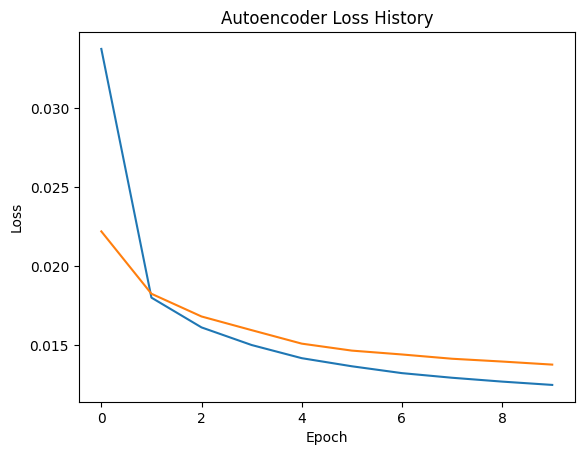

In [9]:
autoencoder_gray.train(train_loader, test_loader, epochs=10, lr=0.001, grayscale_input=True)
autoencoder_gray.plot_loss()

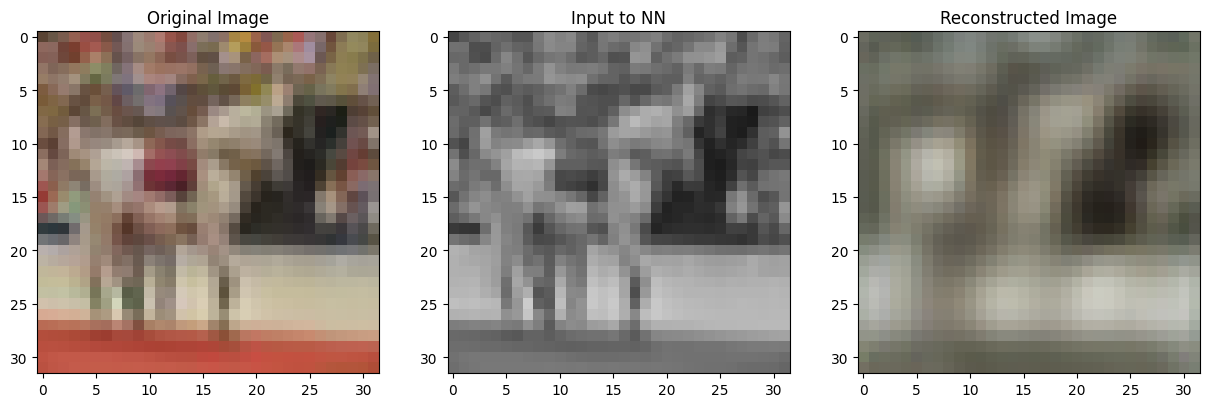

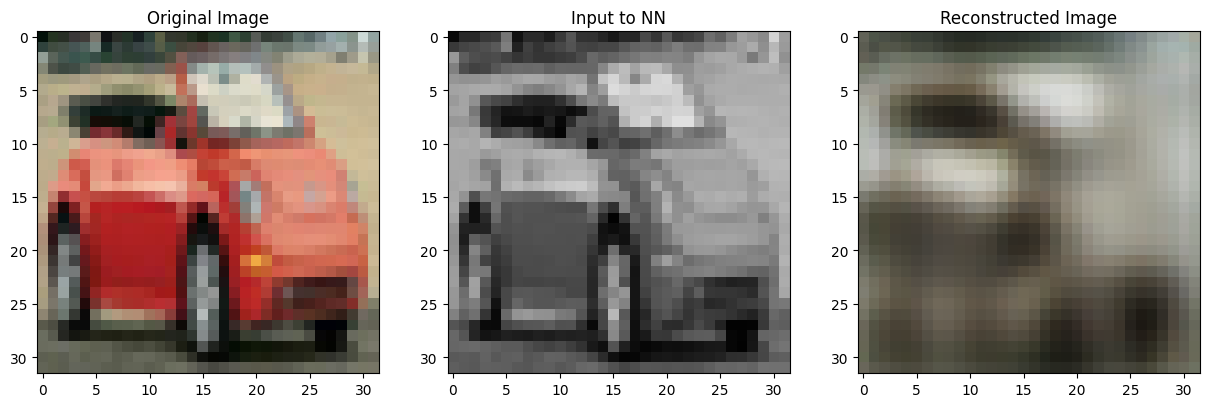

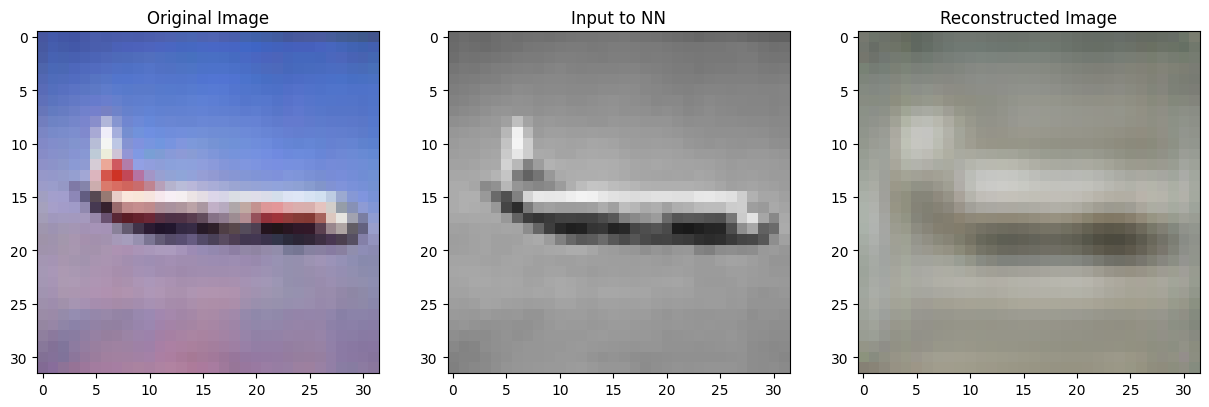

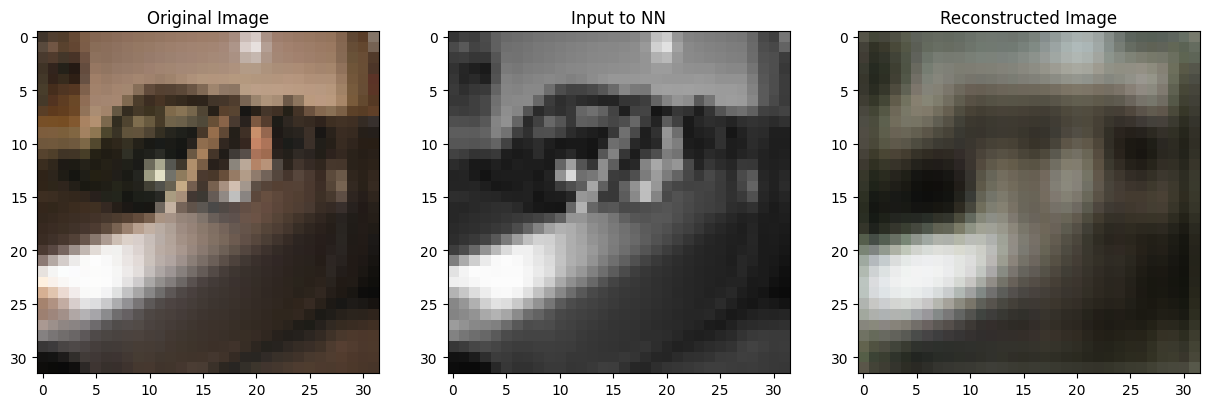

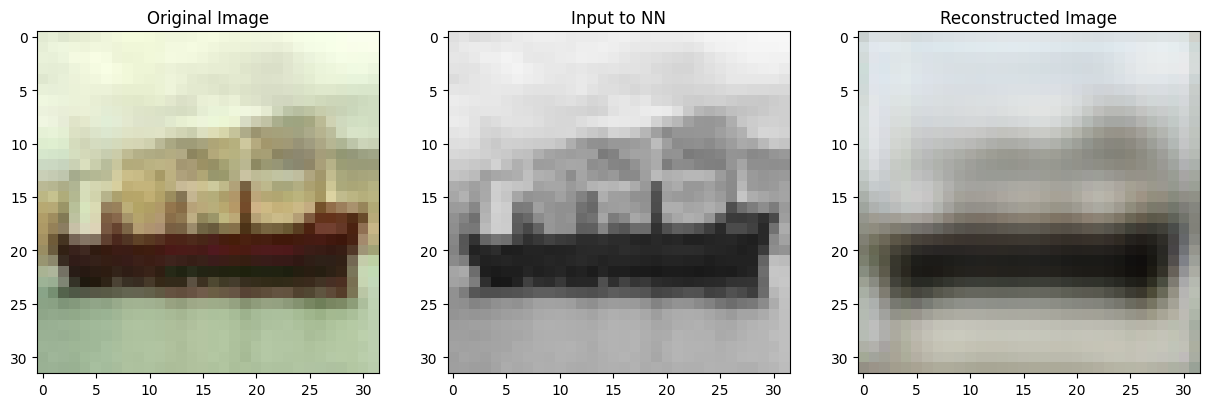

In [10]:
plot_examples(autoencoder_gray, num_examples=5, grayscale=True)